In [56]:
import numpy as np
import scipy.linalg
from collections import defaultdict, namedtuple, Counter
from itertools import combinations
import numpy as np
import scipy.stats as stats
import sys
from os import listdir
import json
import random
import csv
import sys
import cvxpy as cp
import matplotlib.pyplot as plt

In [4]:
dataset = 'recomb_spark'

# First, let's look at head circumference

In [93]:
child_to_headcirc = dict()
with open('../../PhasingFamilies/phenotypes/ihart/AGRE_PhysMeas1.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    head_circ_index = header.index('Maximum_Head_Circumference')
    age_index = header.index('age')
    id_index = header.index('Individual ID')
    
    for pieces in reader:
        c = float(pieces[head_circ_index])
        if c != 0 and c != -1:
            child_to_headcirc[pieces[id_index]] = c
    
    

In [239]:
ped_file = '../../DATA/ihart.ms2/ihart.ped'

# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
mother_to_children = defaultdict(set)
father_to_children = defaultdict(set)
child_to_mother = dict()
child_to_father = dict()

with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            
            if 'LCL' not in child_id and f_id != '0' and m_id != '0':
                mother_to_children[m_id].add(child_id)
                father_to_children[f_id].add(child_id)
                child_to_mother[child_id] = m_id
                child_to_father[child_id] = f_id


print('ped loaded')


ped loaded


In [240]:
sibpairs = []

# pull identicals
with open('../../PhasingFamilies/phased_ihart.ms2_quads_del/identicals.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[2] == 'identical':
            sibs = [pieces[0], pieces[1]]
            random.shuffle(sibs)
            if sibs[0] in child_to_headcirc and sibs[1] in child_to_headcirc:
                sibpairs.append((sibs, 'identical'))
            
# pull full sibs and mat half sibs
for mother, children in mother_to_children.items():
    for sib1, sib2 in combinations(children, r=2):
        sibs = [sib1, sib2]
        random.shuffle(sibs)
        if sibs[0] in child_to_headcirc and sibs[1] in child_to_headcirc:
            if child_to_father[sib1] == child_to_father[sib2]:
                sibpairs.append((sibs, 'full'))
            else:
                sibpairs.append((sibs, 'mat half'))
            
# pull pat half sibs
for father, children in father_to_children.items():
    for sib1, sib2 in combinations(children, r=2):
        sibs = [sib1, sib2]
        random.shuffle(sibs)
        if sibs[0] in child_to_headcirc and sibs[1] in child_to_headcirc:
            if child_to_mother[sib1] != child_to_mother[sib2]:
                sibpairs.append((sibs, 'pat half'))
                



In [241]:
# you need to interrupt this after a few seconds, because it just keeps going - no need to have all pairs

children = set(sum([list(x) for x in mother_to_children.values()], []))

for sib1, sib2 in combinations(children, r=2):
    if child_to_father[sib1] != child_to_father[sib2] and child_to_mother[sib1] != child_to_mother[sib2]:
        sibs = [sib1, sib2]
        random.shuffle(sibs)
        if sibs[0] in child_to_headcirc and sibs[1] in child_to_headcirc:
            sibpairs.append((sibs, 'unrelated'))

KeyboardInterrupt: 

In [242]:
circ = np.array([child_to_headcirc[sibpair[0][0]]-child_to_headcirc[sibpair[0][1]] for sibpair in sibpairs])
is_identical = np.array([sibpair[1]=='identical' for sibpair in sibpairs])
is_full = np.array([sibpair[1]=='full' for sibpair in sibpairs])
is_half_mat = np.array([sibpair[1]=='mat half' for sibpair in sibpairs])
is_half_pat = np.array([sibpair[1]=='pat half' for sibpair in sibpairs])
is_unrelated = np.array([sibpair[1]=='unrelated' for sibpair in sibpairs])
print(np.sum(is_identical), np.sum(is_full), np.sum(is_half_mat|is_half_pat), np.sum(is_unrelated))

55 1391 101 909419


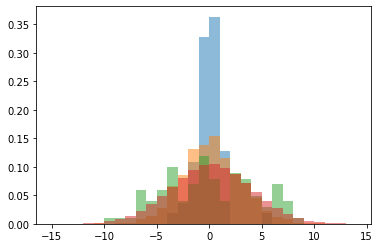

In [243]:
plt.hist(circ[is_identical], bins=np.arange(-15, 15), alpha=0.5, density=True)
plt.hist(circ[is_full], bins=np.arange(-15, 15), alpha=0.5, density=True)
plt.hist(circ[is_half_mat | is_half_pat], bins=np.arange(-15, 15), alpha=0.5, density=True)
plt.hist(circ[is_unrelated], bins=np.arange(-15, 15), alpha=0.5, density=True)

plt.show()

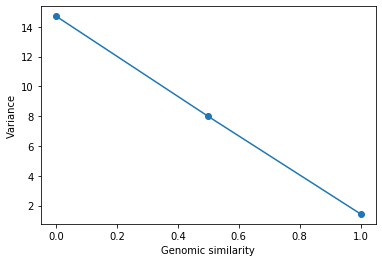

-13.269574341627226 14.674251284023862


In [263]:
plt.plot([0, 0.5, 1], [np.var(circ[is_unrelated]), np.var(circ[is_full]), np.var(circ[is_identical])], marker='o')
plt.xlabel('Genomic similarity')
plt.ylabel('Variance')
plt.show()

m, b = np.polyfit([0, 0.5, 1], 
                  [np.var(circ[is_unrelated]), np.var(circ[is_full]), np.var(circ[is_identical])], 
                  1)
print(m, b)

In [247]:
# we conclude that var is linear in genomic similarity

# Now let's expand to include more detailed genomic similarity
## We also switch to using  SPARK rather than iHART

In [393]:
with open('../../PhasingFamilies/%s/sibpairs.json' % dataset, 'r') as f:
	sibpairs = json.load(f)
    
# These lines include identical sibpairs into the analysis

#with open('../../PhasingFamilies/%s/identical_sibpairs.json' % dataset, 'r') as f:
#	sibpairs.extend(json.load(f))
    
print('Overall')
print('families', len(set([x['family'].split('.')[0] for x in sibpairs])))
print('sibpairs', len(sibpairs))
num_sibpairs = len(sibpairs)

Overall
families 5579
sibpairs 6925


In [394]:
sample_to_affected = dict()
with open('../../PhasingFamilies/phenotypes/spark_v5/spark_v5-scq-prep.csv', 'r') as f:
    reader = csv.reader(f)
    for pieces in reader:
        sample_to_affected[pieces[2]] = pieces[13:53]

In [395]:
sibpairs = [x for x in sibpairs if x['sibling1'] in sample_to_affected and x['sibling2'] in sample_to_affected]
for sibpair in sibpairs:
    if random.randint(1, 2)==1:
        sibpair['sibling1'], sibpair['sibling2'] = sibpair['sibling2'], sibpair['sibling1']
print(len(sibpairs))


5376


In [396]:
X = np.array([[sibpair['maternal_ibd'], sibpair['paternal_ibd']] for sibpair in sibpairs])

P = np.array([[-1 if ((x not in {'1.0', '0.0'}) or (y not in {'1.0', '0.0'})) else int(x!=y) for x, y in zip(sample_to_affected[sibpair['sibling1']], sample_to_affected[sibpair['sibling2']])] for sibpair in sibpairs])

print(X.shape, P.shape, z.shape)


(5376, 2) (5376, 40) (5376, 40)


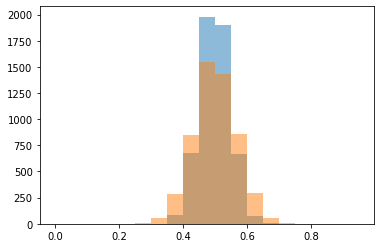

maternal 0.4998627824746505 0.002145117982940212
paternal 0.4994006715670778 0.004319432963119714


In [437]:
plt.hist(X[:, 0], alpha=0.5, bins=np.arange(0, 1, 0.05))
plt.hist(X[:, 1], alpha=0.5, bins=np.arange(0, 1, 0.05))
plt.show()

print('maternal', np.mean(X[:, 0]), np.var(X[:, 0]))
print('paternal', np.mean(X[:, 1]), np.var(X[:, 1]))

In [ ]:
# Paternal similarity has a higher variance than maternal similarity
# Both have means near 0.5 as expected

In [440]:
# Below we do MLE
# We assume Y is a random variable in {-1, 0, 1}
# We know that the distribution of Y must be symmetric (by symmetry of sibpairs)
# From head circumference, we know we want to model var(Y) = a*g_mat + b*g_pat + e
# where a captures the variance component driven by maternal genomic similarity, 
# b captures the variance component driven by paternal genomic similarity
# and e is all the rest of the variance
# we expect a, b <= 0 and e >= 0

# Let 
# p_1 = P[Y=-1]
# p_2 = P[Y=0]
# p_3 = P[Y=1]

# by symmetry p_1 = p_3

# by definition, since E[Y] = 0,
# var(Y) = p_1(-1)^2 + p_2(0)^2 + p_3(1)^2
#        = 2p_1
# p_1 = var(Y)/2
# p_2 = 1 - var(Y)
# p_3 = var(Y)/2

# putting this all together, the log likelihood of our data under this model is
# \sum_{Y_i in {-1, 1}} \log(a*g_mat^i + b*g_pat^i + e)/2
# + \sum_{Y_i = 0} \log(1- (a*g_mat^i + b*g_pat^i + e))

# Luckily for us, the above is concave, so we solve with cvxpy
# Then we do a bunch of permutation tests to figure out if anything is meaningful

In [398]:
var_components = np.zeros((40, 3))
var_baseline = np.zeros((40, 3, 100))

indices = np.arange(0, X.shape[0])

for phen_index in range(40):
    print(phen_index, end=' ')
    a = cp.Variable()
    b = cp.Variable()
    #c = cp.Variable()
    e = cp.Variable()

    v = a*X[:, 0] + b*X[:, 1] + e
    prob = cp.Problem(cp.Maximize(cp.sum(cp.log(v[P[:, phen_index]==1]/2)) + cp.sum(cp.log(1-v[P[:, phen_index]==0]))),
                     [a<=0, b<=0, e>=0])
    prob.solve(solver='ECOS')
    
    var_components[phen_index, :] = [a.value, b.value, e.value]
    

    for j in range(100):
        np.random.shuffle(indices)
        Z = X[indices, :]#
    
        a = cp.Variable()
        b = cp.Variable()
        #c = cp.Variable()
        e = cp.Variable()
    
        v = a*Z[:, 0] + b*Z[:, 1] + e
        prob = cp.Problem(cp.Maximize(cp.sum(cp.log(v[P[:, phen_index]==1]/2)) + cp.sum(cp.log(1-v[P[:, phen_index]==0]))),
                         [a<=0, b<=0, e>=0])
        prob.solve(solver='ECOS')#
    
        var_baseline[phen_index, :, j] = [a.value, b.value, e.value]


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 

0.82


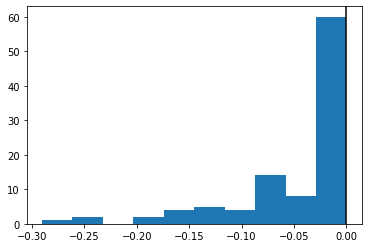

In [441]:
plt.hist(var_baseline[0, 0, :])
plt.axvline(var_components[0, 0], color='black')
print(np.sum(var_baseline[0, 0, :] <= var_components[0, 0])/100)

In [442]:
bootstrap_pvalues = np.ones((40, 3))
for i in range(40):
    bootstrap_pvalues[i, :] = np.sum(var_components[i, 0] >= var_baseline[i, 0, :])/100, \
          np.sum(var_components[i, 1] >= var_baseline[i, 1, :])/100, \
          np.sum(var_components[i, 0]+var_components[i, 1] >= var_baseline[i, 0, :]+var_baseline[i, 1, :])/100
          

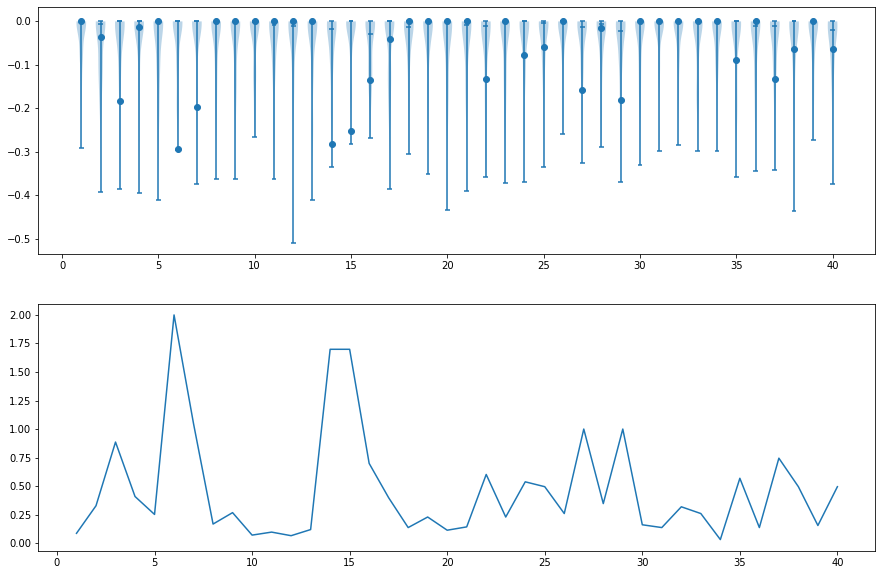

In [443]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.violinplot(var_baseline[:, 0, :].T, showmedians=True)
plt.scatter(np.arange(1, 41), var_components[:, 0])

plt.subplot(2, 1, 2)
plt.plot(np.arange(1, 41), np.clip(-np.log10(bootstrap_pvalues[:, 0]), None, 3))
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


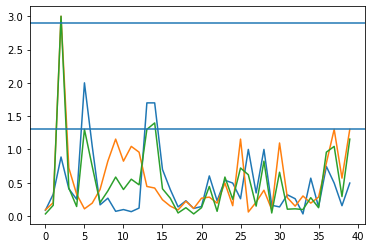

SCQ 3 [0.13 0.   0.  ] ['-0.18', '-0.37', '0.92'] ['-0.18', '-0.37', '0.92']
[0.19917641 0.39676137] 0.5959377820167263
[0.19917641 0.39676137] 0.5959377820167263
SCQ 6 [0.01 0.78 0.05] ['-0.29', '0.00', '0.66'] ['-0.29', '0.00', '0.66']
[ 4.48916591e-01 -1.16419773e-09] 0.4489165901087242
[ 4.48916591e-01 -1.16419773e-09] 0.4489165901087242
SCQ 14 [0.02 0.36 0.05] ['-0.28', '-0.04', '0.70'] ['-0.28', '-0.04', '0.70']
[0.40239516 0.06380477] 0.4661999346819449
[0.40239516 0.06380477] 0.4661999346819449
SCQ 15 [0.02 0.38 0.04] ['-0.25', '-0.02', '0.75'] ['-0.25', '-0.02', '0.75']
[0.33743224 0.02967833] 0.3671105726289542
[0.33743224 0.02967833] 0.3671105726289542


In [444]:
plt.plot(np.clip(-np.log10(bootstrap_pvalues[:, 0]), None, 3))
plt.plot(np.clip(-np.log10(bootstrap_pvalues[:, 1]), None, 3))
plt.plot(np.clip(-np.log10(bootstrap_pvalues[:, 2]), None, 3))
plt.axhline(-np.log10(0.05/40))
plt.axhline(-np.log10(0.05))
plt.show()

for i in range(40):
    if np.any(bootstrap_pvalues[i, :]<0.05):
        print('SCQ', i+1, bootstrap_pvalues[i, :], ['%0.2f' % x for x in var_components[i, :]], 
              ['%0.2f' % x for x in var_components[i, :]])
        print(-var_components[i, :2]/var_components[i, 2], -np.sum(var_components[i, :2])/var_components[i, 2])
        print(-var_components[i, :2]/var_components[i, 2], -np.sum(var_components[i, :2])/var_components[i, 2])
        
        

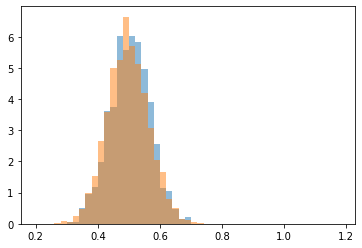

In [445]:
phen_index = 2
plt.hist(X[P[:, phen_index]==0, 1], alpha=0.5, bins=np.arange(0.2, 1.2, 0.02), density=True)
plt.hist(X[P[:, phen_index]==1, 1], alpha=0.5, bins=np.arange(0.2, 1.2, 0.02), density=True)
plt.show()

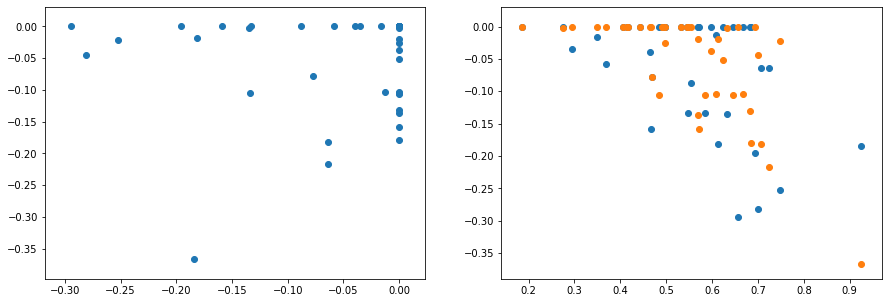

In [446]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(var_components[:, 0], var_components[:, 1])

plt.subplot(1, 2, 2)
plt.scatter(var_components[:, 2], var_components[:, 0])
plt.scatter(var_components[:, 2], var_components[:, 1])

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


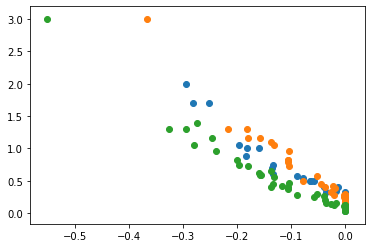

In [447]:
plt.scatter(var_components[:, 0], np.clip(-np.log10(bootstrap_pvalues[:, 0]), None, 3))
plt.scatter(var_components[:, 1], np.clip(-np.log10(bootstrap_pvalues[:, 1]), None, 3))
plt.scatter(var_components[:, 0]+var_components[:, 1], np.clip(-np.log10(bootstrap_pvalues[:, 2]), None, 3))